# <center> Feature selection in regression using correlation

### Importing necessary libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder,StandardScaler,RobustScaler
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor,GradientBoostingRegressor
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.feature_selection import SelectKBest,f_regression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import LinearSVR
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('./CarPricesData.csv')
data

,Price,Age,KM,FuelType,HP,MetColor,Automatic,CC,Doors,Weight
0,13500,23.0,46986,Diesel,90,1,0,2000.0,3,1165.0
1,13750,23.0,72937,Diesel,90,1,0,2000.0,3,1165.0
2,13950,24.0,41711,Diesel,90,1,0,2000.0,3,1165.0
3,14950,26.0,48000,Diesel,90,0,0,2000.0,3,1165.0
4,13750,30.0,38500,Diesel,90,0,0,2000.0,3,1170.0
...,...,...,...,...,...,...,...,...,...,...
1431,7500,69.0,20544,Petrol,86,1,0,1300.0,3,1025.0
1432,10845,72.0,19000,Petrol,86,0,0,1300.0,3,1015.0
1433,8500,71.0,17016,Petrol,86,0,0,1300.0,3,1015.0
1434,7250,70.0,16916,Petrol,86,1,0,1300.0,3,1015.0


### Descriptive statistics

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1436 entries, 0 to 1435
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Price      1436 non-null   int64  
 1   Age        1434 non-null   float64
 2   KM         1436 non-null   int64  
 3   FuelType   1432 non-null   object 
 4   HP         1436 non-null   int64  
 5   MetColor   1436 non-null   int64  
 6   Automatic  1436 non-null   int64  
 7   CC         1434 non-null   float64
 8   Doors      1436 non-null   int64  
 9   Weight     1434 non-null   float64
dtypes: float64(3), int64(6), object(1)
memory usage: 112.3+ KB


In [4]:
data.duplicated().sum()

1

In [5]:
data.isnull().mean()*100

Price        0.000000
Age          0.139276
KM           0.000000
FuelType     0.278552
HP           0.000000
MetColor     0.000000
Automatic    0.000000
CC           0.139276
Doors        0.000000
Weight       0.139276
dtype: float64

In [6]:
data.fillna(method='bfill',inplace=True)

In [7]:
data.isnull().mean()*100

Price        0.0
Age          0.0
KM           0.0
FuelType     0.0
HP           0.0
MetColor     0.0
Automatic    0.0
CC           0.0
Doors        0.0
Weight       0.0
dtype: float64

### Label encoding

In [8]:
le = LabelEncoder()

In [9]:
data['FuelType'] = le.fit_transform(data.FuelType)

### EDA

### Histogram

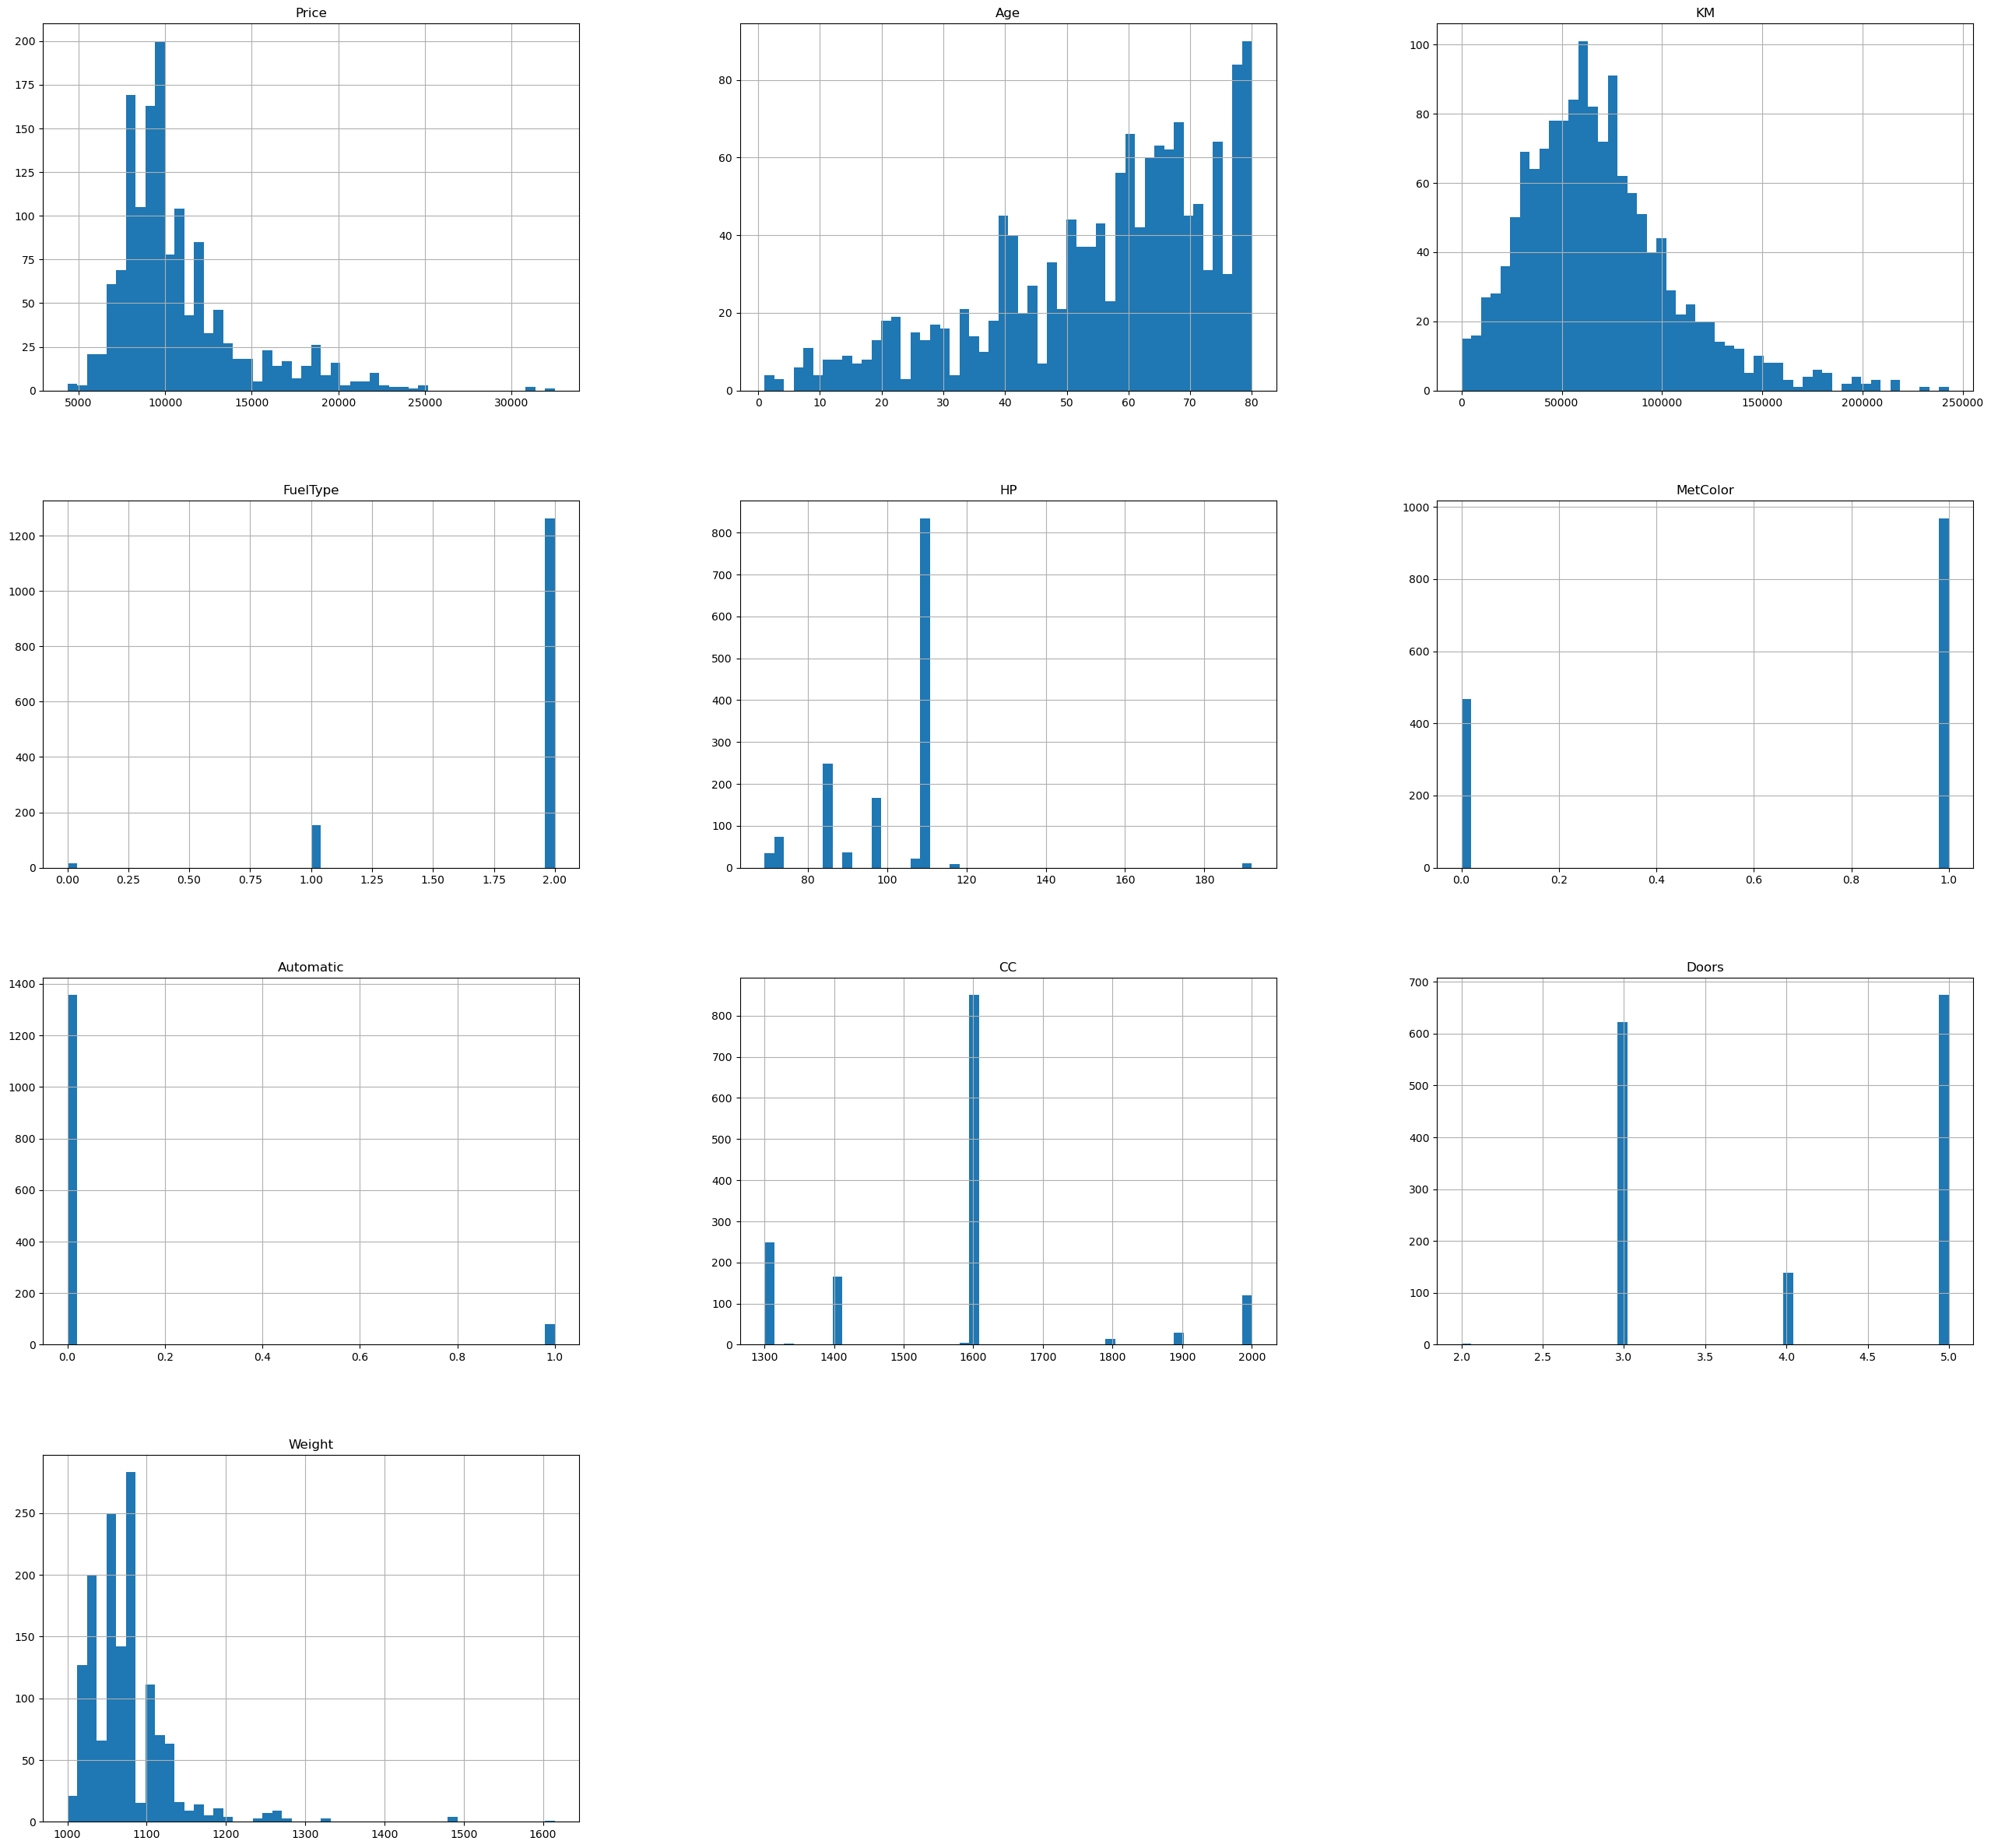

In [10]:
data.hist(bins=50,figsize=(32,30));

### Box plot

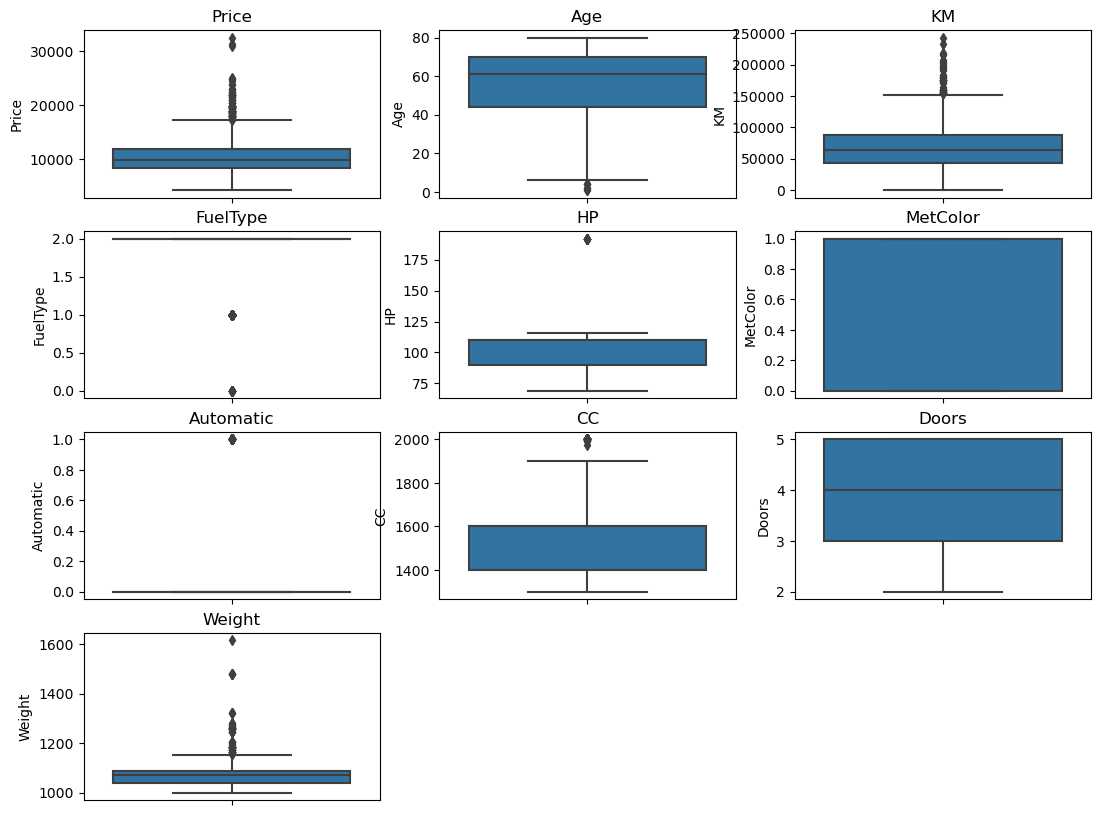

In [11]:
plt.figure(figsize=(13,10))
for i in enumerate(data.columns):
    plt.subplot(4,3,i[0]+1)
    plt.title(i[1])
    sns.boxplot(data=data,y=i[1])
   

### Histogram

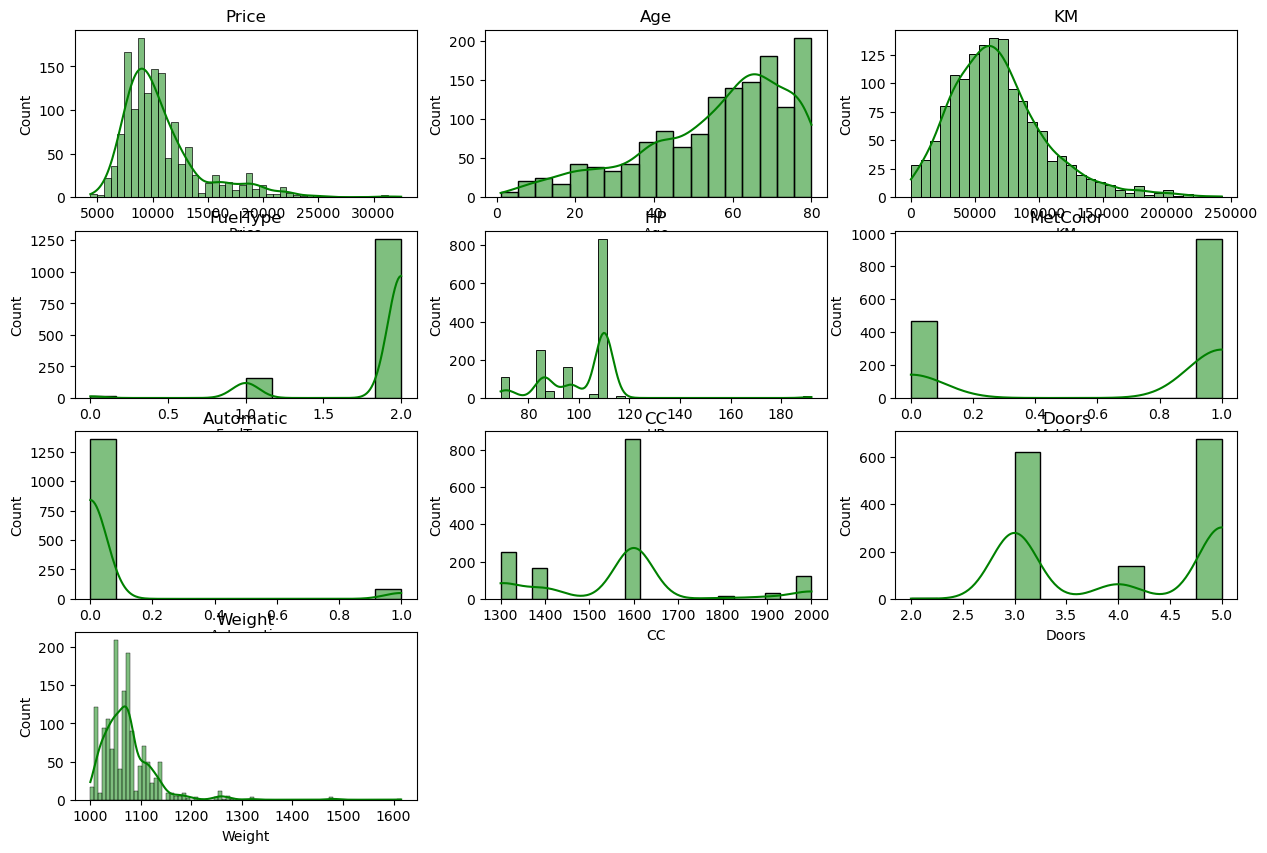

In [12]:
plt.figure(figsize=(15,10))
for i in enumerate(data.columns):
    plt.subplot(4,3,i[0]+1)
    plt.title(i[1])
    sns.histplot(data=data,x=i[1],kde=True,color='green')


### Heat map

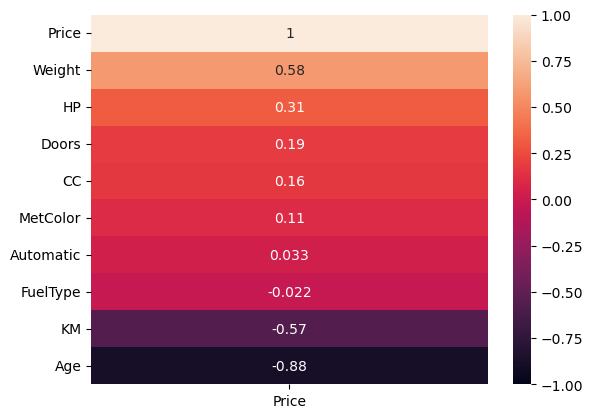

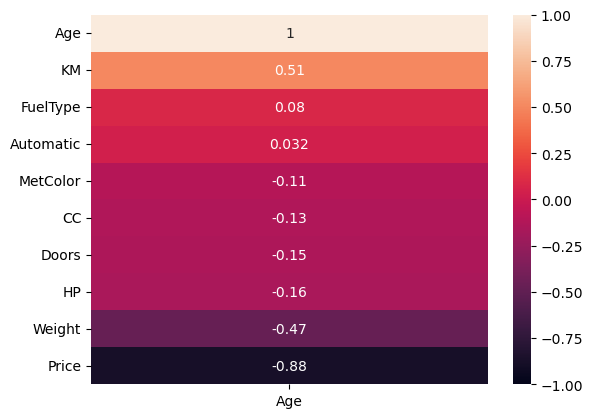

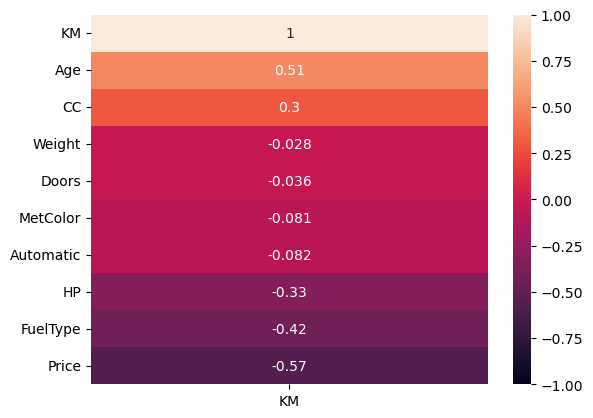

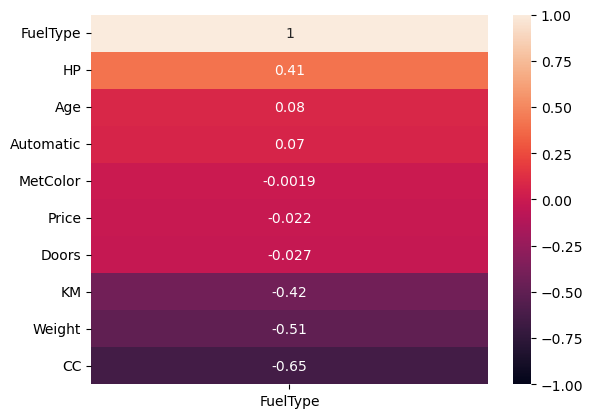

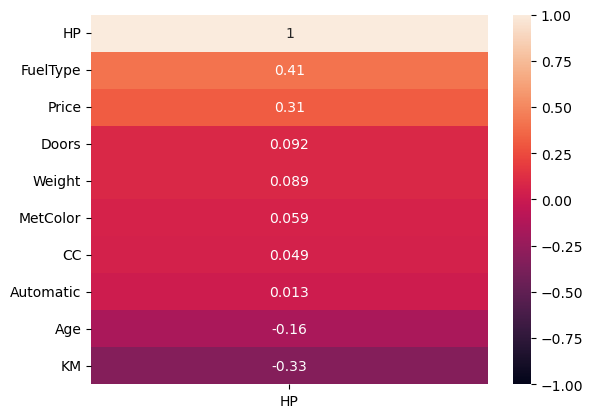

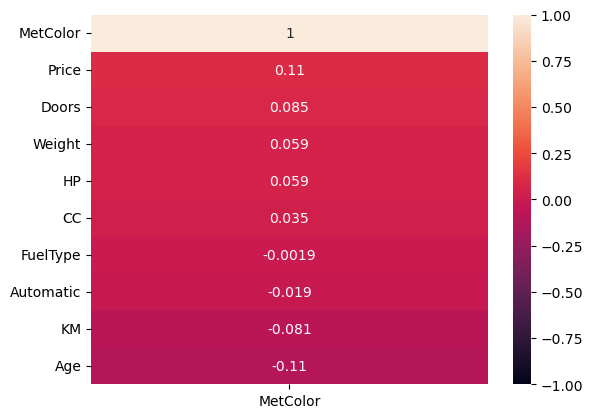

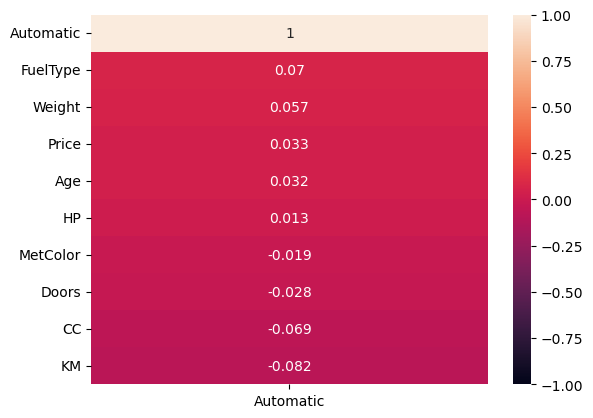

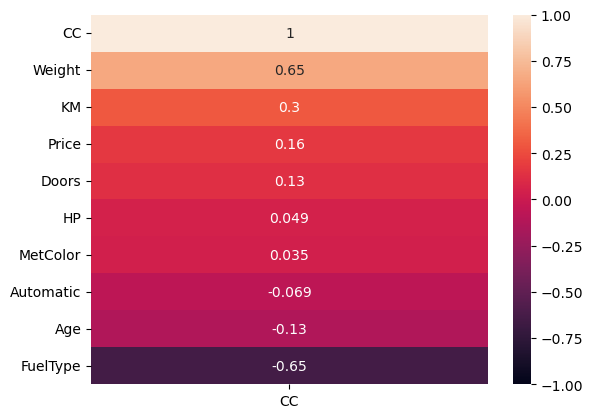

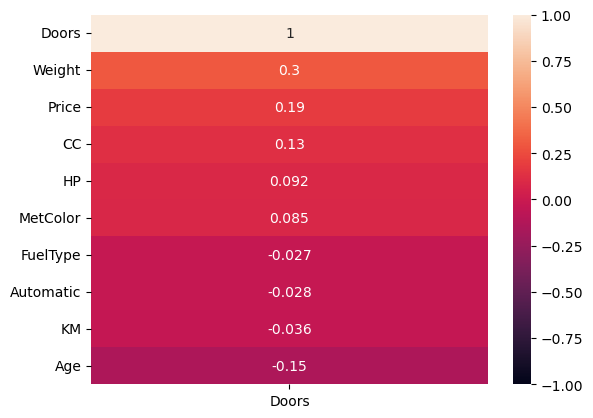

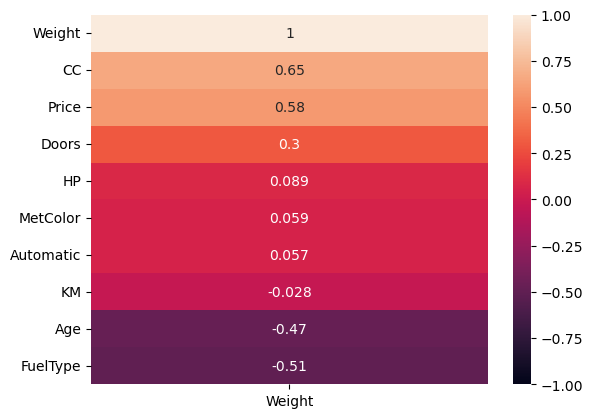

In [13]:

for i in data.columns:
    sns.heatmap(data.corr()[[i]].sort_values(by=i,ascending=False),vmax=1,vmin=-1,annot=True)
    plt.show()

### Outlier treatment

In [14]:
def outlier_limit(col):
    Q3,Q1 = np.nanpercentile(col,[75,25])
    IQR = Q3-Q1
    UL = Q3+1.5*IQR
    LL = Q1-1.5*IQR
    return UL,LL
    

In [15]:
UL,LL = outlier_limit(data['Price'])
data['Price'] = np.where((data['Price']>UL)|(data['Price']<LL),np.nan,data['Price'])


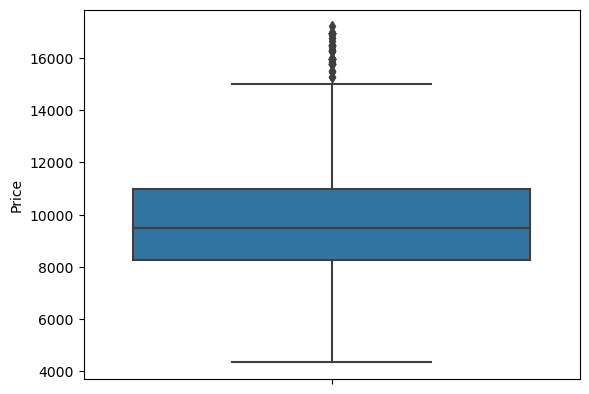

In [16]:
sns.boxplot(data=data,y='Price');

In [17]:
data.dropna(inplace=True)

### Selecting feature and target variables

In [18]:
data.head()

,Price,Age,KM,FuelType,HP,MetColor,Automatic,CC,Doors,Weight
0,13500.0,23.0,46986,1,90,1,0,2000.0,3,1165.0
1,13750.0,23.0,72937,1,90,1,0,2000.0,3,1165.0
2,13950.0,24.0,41711,1,90,1,0,2000.0,3,1165.0
3,14950.0,26.0,48000,1,90,0,0,2000.0,3,1165.0
4,13750.0,30.0,38500,1,90,0,0,2000.0,3,1170.0


In [19]:
x = data.iloc[:,1:].values

In [20]:
y = data.iloc[:,0].values

In [21]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=42)

In [22]:
x_test.shape

(266, 9)

### Scaling

In [23]:
rs = RobustScaler()

In [24]:
x = rs.fit_transform(x)

### Feature selection

In [25]:
fs = SelectKBest(score_func=f_regression,k='all')

In [26]:
fs.fit(x_train,y_train)

SelectKBest(k='all', score_func=<function f_regression at 0x000001F4C9CB91F0>)

In [27]:
for i in range(len(fs.scores_)):
    print('Feature %d : %f' % (i,fs.scores_[i]))

Feature 0 : 2488.529776
Feature 1 : 397.126358
Feature 2 : 7.921163
Feature 3 : 54.596747
Feature 4 : 7.868048
Feature 5 : 0.273918
Feature 6 : 0.053512
Feature 7 : 28.863013
Feature 8 : 107.240854


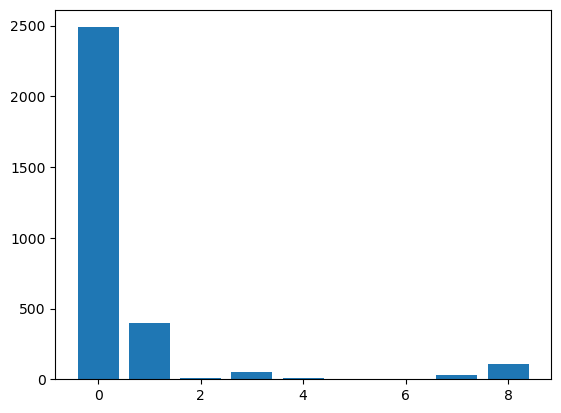

In [28]:
plt.bar([i for i in range(len(fs.scores_))],fs.scores_);

The plot clearly shows 4 features are a lot more important than the other features.

We could set k=4 When configuring the SelectKBest to select these top features.

In [29]:
fs = SelectKBest(score_func=f_regression,k=2)

In [30]:
fs.fit(x_train,y_train)

SelectKBest(k=2, score_func=<function f_regression at 0x000001F4C9CB91F0>)

In [31]:
x_train_fs = fs.transform(x_train)
x_test_fs = fs.transform(x_test)

In [32]:
x_test_fs.shape

(266, 2)

### Cross validation

In [33]:
models = {
    'LinearRegression':LinearRegression(),
    'Ridge':Ridge(),
    'Lasso':Lasso(),
    'RandomForestRegressor':RandomForestRegressor(),
    'GradientBoostingRegressor':GradientBoostingRegressor(),
    'AdaBoostRegressor':AdaBoostRegressor(),
    'LinearSVR':LinearSVR(),
    'DecisionTreeRegressor':DecisionTreeRegressor()
}

In [34]:
for name,model in models.items():
    score = cross_val_score(model,x,y,scoring='neg_mean_squared_error',cv=10,n_jobs=-1)
    rmse = np.sqrt(-score)
    avg_rmse = np.mean(rmse)
    print('Cross validation Model: ',format(name))
    print('Avg rmse',avg_rmse)
    print('*'*100)

Cross validation Model:  LinearRegression
Avg rmse 1138.686341926637
****************************************************************************************************
Cross validation Model:  Ridge
Avg rmse 1138.8039295333674
****************************************************************************************************
Cross validation Model:  Lasso
Avg rmse 1138.5199764916902
****************************************************************************************************
Cross validation Model:  RandomForestRegressor
Avg rmse 1225.2659495650357
****************************************************************************************************
Cross validation Model:  GradientBoostingRegressor
Avg rmse 1144.1512084182425
****************************************************************************************************
Cross validation Model:  AdaBoostRegressor
Avg rmse 1268.765620105293
************************************************************************************

#### Linear reg model has less avg rmse. It is considered to be the best model. 

In [35]:
model = LinearRegression()

In [36]:
model.fit(x_train_fs,y_train)

LinearRegression()

In [37]:
training_score = model.score(x_train_fs,y_train)*100
testing_score = model.score(x_test_fs,y_test)*100
y_pred = model.predict(x_test_fs)
r2_Score = r2_score(y_test,y_pred)
mae = mean_absolute_error(y_test,y_pred)
mse = mean_squared_error(y_test,y_pred)
print('Training score: ',training_score)
print('Testing score: ',testing_score)
print('r2 Score: ',r2_Score)
print('MAE: ',mae)
print('MSE: ',mse)

Training score:  74.66866737705257
Testing score:  78.3402160646534
r2 Score:  0.783402160646534
MAE:  856.9768016550607
MSE:  1235614.8905970794


In [38]:
output = pd.DataFrame(zip(y_test,y_pred),columns=['Actual','Predicted'])
output

,Actual,Predicted
0,10950.0,10681.444021
1,11950.0,10892.193565
2,9950.0,9963.990178
3,11950.0,12461.690208
4,9800.0,8228.248479
...,...,...
261,10250.0,10119.462815
262,7500.0,7192.015221
263,8250.0,9146.842437
264,7450.0,7519.717439


In [39]:
output['Error'] = output['Actual'] - output['Predicted']


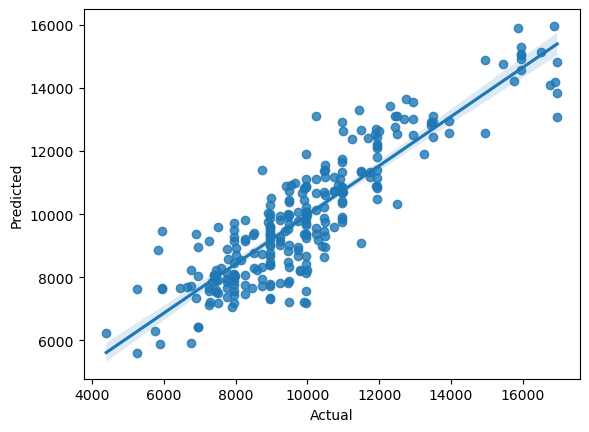

In [40]:
sns.regplot(data=output,x='Actual',y='Predicted');

### Normality in error checking 

<AxesSubplot:xlabel='Error', ylabel='Count'>

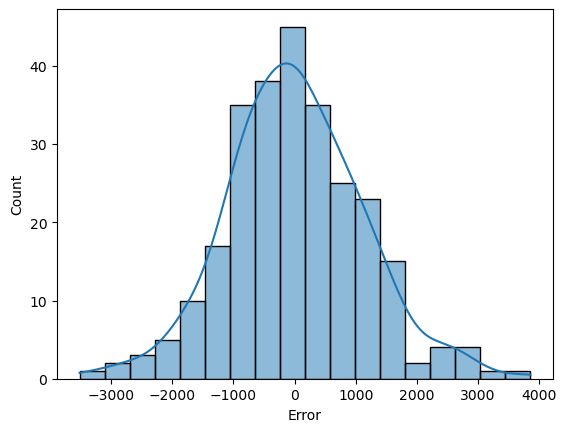

In [41]:
sns.histplot(data=output,x='Error',kde=True)

#### Linear regression is considered to be the best model.The prediction is approximately accurate